In [2]:
import os
import sys
import pickle

from time import sleep
from time import time
from random import randint

import cv2
import numpy as np
#import mpld3

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.utils import shuffle

IMG_SIZE = (30, 30) # Size of image (e.g. 30x30) to be used as feature vector of length (e.g. 900x1)
PIXEL_DEPTH = 255.0  # Number of levels per pixel.

### Dataset routines ###

In [3]:
def make_feature_vec(img):
    """Resize an 'img' to correct size and 
    flatten rows x cols matrix to vector of rows ((30, 30) => (900, 1))
    """
    if img.shape[:2] != IMG_SIZE:
        img = cv2.resize(img, IMG_SIZE)
    return normalize(np.reshape(img, -1))

def load_dataset(path, dataset_size=-1, downsample=True):
    """Loads samples from image files (e.g '001.png').
    Args:
        path -- path to the images(samples) (default size: 60px X 60px)
        dataset_size -- number of samples to read
        downsample -- downsamples input sample(img) if True
    Returns:
        images -- array (n, 900) of sample vectors (900, 1) as rows
    """
    image_files = os.listdir(path)[:dataset_size]
    # Init 'images' array as samples X features matrix
    images = np.ndarray(shape=(len(image_files), IMG_SIZE[0] * IMG_SIZE[1]), 
                        dtype=np.float32)
    image_idx = 0
    for filename in image_files:
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        if downsample:
            # Downsample image (scale down by 50%)
            img = cv2.pyrDown(img)
        if img.shape[:2] != IMG_SIZE:
            continue
        # Convert img matrix to proper format vector (900, 1)
        # Normalize (mean=0, stdev~=0.5)
        images[image_idx, :] = make_feature_vec(img)
        image_idx += 1
    return images

def label_dataset(pos_data, neg_data):
    """Prepare dataset. Combime pos and neg examples, label it & shuffle it.
    Args:
        pos_data -- array of positive samples
        neg_data -- array of negative samples
    Returns:
        dataset -- samples array
        labels -- labels vec
    """
    num_pos_samples = pos_data.shape[0]
    num_neg_samples = neg_data.shape[0] 
    num_total = num_pos_samples + num_neg_samples
    dataset = np.vstack((pos_data, neg_data[:num_neg_samples])).astype(np.float64)
    labels = np.ones([num_total], dtype=np.int32)
    # Label
    labels[num_pos_samples + 1:] = 0
    # Shuffle
    return shuffle(dataset, labels, random_state=0)

def normalize(img):
    """Normalize to have approximately zero mean and standard deviation ~0.5 
    to make training easier down the road. 
    """
    mean = PIXEL_DEPTH / 2
    return (img - mean) / PIXEL_DEPTH

def preview(sample_vec):
    %matplotlib inline
    #mpld3.enable_notebook()
    plt.imshow(sample_vec.reshape(IMG_SIZE))
    
def preview_random_examples(pos_data, neg_data):
    %matplotlib inline
    #mpld3.enable_notebook()
    plt.figure(1)
    pos_idx = randint(1, len(pos_data))
    plt.title('POSITIVE (ex. #{})'.format(pos_idx))
    plt.imshow(pos_data[pos_idx].reshape(IMG_SIZE))

    plt.figure(2)
    neg_idx = randint(1, len(neg_data))
    plt.title('NEGATIVE (ex.#{})'.format(neg_idx))
    plt.imshow(neg_data[neg_idx].reshape(IMG_SIZE))
    plt.show()

### Load positive and negative examples from files into feature vectors ###

In [4]:
pos_path = './dataset/positive/'
neg_path = './dataset/negative/'
pos_data = load_dataset(path=pos_path, downsample=True)
neg_data = load_dataset(path=neg_path, downsample=True)
X, y = label_dataset(pos_data, neg_data)

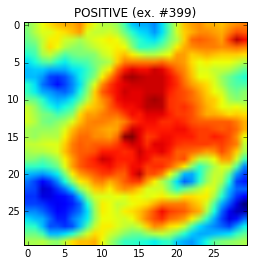

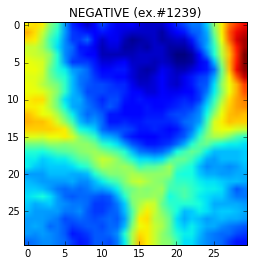

In [29]:
preview_random_examples(pos_data, neg_data)

### Spilt data to training, validation and test sets (60%, 20%, 20%) ###

In [30]:
idx_train = int(X.shape[0] * 0.6)
idx_cv = idx_train + int(X.shape[0] * 0.2)
X_train = X[:idx_train]
y_train = y[:idx_train]
X_cv = X[idx_train:idx_cv]
y_cv = y[idx_train:idx_cv]
X_test = X[idx_cv:]
y_test = y[idx_cv:]

print('No samples missed during spliting: {}'.format(len(y) == len(y_train) + len(y_cv) + len(y_test)))

No samples missed during spliting: True


### ============================================================= ###
### Train SVM with Gaussian (rbf') kernel ###

In [72]:
C = 0.85
clf = svm.SVC(kernel='rbf', C=C, probability=True)

#SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
#  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
#  max_iter=-1, probability=False, random_state=None, shrinking=True,
#  tol=0.001, verbose=False)

In [74]:
# Train SVC
dataset_sizes = [200, 500, 1000, y_train.shape[0]]
dataset_idx = len(dataset_sizes)
train_scores = []
cv_scores = []
for n in dataset_sizes[:dataset_idx]:
    clf.fit(X_train[:n], y_train[:n])
    train_scores.append(clf.score(X_train, y_train))
    cv_scores.append(clf.score(X_cv, y_cv))
    print('Training set size: {}\nAccuracy on CV set: {:0.3f}' \
          .format(n, cv_scores[dataset_sizes.index(n)]))
print('Test set accuracy: {:0.2f}'.format(clf.score(X_test, y_test)))

Training set size: 200
Accuracy on CV set: 0.809
Training set size: 500
Accuracy on CV set: 0.809
Training set size: 1000
Accuracy on CV set: 0.800
Training set size: 2011
Accuracy on CV set: 0.857
Test set accuracy: 0.88


### Plot training curves ###

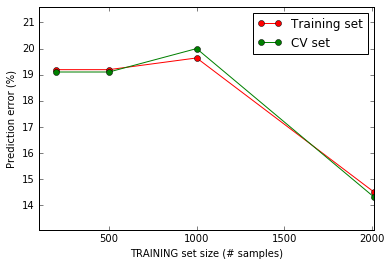

In [75]:
fig, ax = plt.subplots()
ax.plot(dataset_sizes[:dataset_idx], [(1 - i) * 100 for i in train_scores], \
        '-ro', label='Training set')
ax.plot(dataset_sizes[:dataset_idx], [(1 - i) * 100 for i in cv_scores], \
        '-go', label='CV set')
legend = ax.legend(loc='upper right')
plt.axis([100, y_train.shape[0], (1 - max(train_scores)) * 90, (1 - min(train_scores)) * 110])
plt.xlabel('TRAINING set size (# samples)')
plt.ylabel('Prediction error (%)')
plt.show()

### Save classifier to 'clf.pickle' pickles file ###

In [19]:
with open('clf.pickle', 'wb') as handle:
  pickle.dump(clf, handle)

### ============================================================= ###
### Read clf from 'clf.pickle' ###

In [111]:
with open('clf.pickle', 'rb') as handle:
  clf = pickle.load(handle)

### Visualize predicted samples ###

In [118]:
prediction = clf.predict(X_test)
print_list = X_test[prediction == 1]
print_list_len = len(print_list) - 1


Predicted positives visualization:


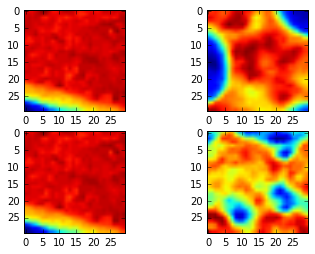

In [119]:
print('\nPredicted positives visualization:')

plt.subplot(221)
plt.imshow(print_list[randint(0, print_list_len)].reshape(IMG_SIZE))

plt.subplot(222)
plt.imshow(print_list[randint(0, print_list_len)].reshape(IMG_SIZE))

plt.subplot(223)
plt.imshow(print_list[randint(0, print_list_len)].reshape(IMG_SIZE))

plt.subplot(224)
plt.imshow(print_list[randint(0, print_list_len)].reshape(IMG_SIZE))

plt.show()

### ============================================================= ###
### Detect capped brood cells on WHOLE image ###
Use classifier on each single sample subimage, acquired with sliding window.
Remember to normalize before prediction!!!

In [89]:
def draw_rect(img, x, y, color):
    cv2.rectangle(img=img, 
                  pt1=(x, y), 
                  pt2=(x + WIN_SIZE, y + WIN_SIZE), 
                  color=color, 
                  thickness=2)
    return img
    
def draw_dot(img, x, y, color):
    cv2.putText(img=img, 
                text='.', 
                org=(x, y + IMG_SIZE[0]),        # TOP LEFT corner if bottomLeftOrigin=False
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=4, 
                color=color, 
                thickness=2, 
                bottomLeftOrigin=False)
    return img

def show(win_name, img):
    cv2.imshow(win_name, img)
    key_pressed = cv2.waitKey(1)
    return key_pressed

def sliding_window_to_feature_vec(image, stepSize, windowSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
            window = image[y:y + windowSize[1], x:x + windowSize[0]]
            yield (x, y, np.array([ make_feature_vec(window) ]))

In [116]:
# Parameters
FILENAME = '003.png'
PATH = '/home/chip/Dropbox/LITS/ML-003/dataset/processed_dataset/prespective_correction'

WIN_SIZE = 55  # Will resize to 30px during processing
STEP = 50
PRED_THRESHOLD = 0.6
WIN_NAME = 'img'
VISUAL = False  # Visualize detection process (INCREASES RUNTIME)

In [117]:
img_path = os.path.join(PATH, FILENAME)
# Read GRAYSCALE img to predict on and COLOR one to show result
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_height, img_width = img.shape[:2]

# Create sliding window generator
samples_gen = sliding_window_to_feature_vec(image=img,
                                            stepSize = STEP,
                                            windowSize=(WIN_SIZE, WIN_SIZE))
cv2.namedWindow(WIN_NAME, cv2.WINDOW_NORMAL)
# Iterate through all the generated samples
for x, y, sample in samples_gen:
    if clf.predict_proba(sample)[0][1] > PRED_THRESHOLD:
    #if clf.decision_function(sample) > -0.2:
        draw_rect(img_rgb, x, y, (0, 255, 0))
    else:
        draw_dot(img_rgb, x, y, (0, 0, 255))
    if VISUAL:
        key = show(WIN_NAME, img_rgb)
        if key == ord('q'):
            break
while True:
    key = show(WIN_NAME, img_rgb)
    if key == ord('q'):
        break
cv2.destroyAllWindows()